# Example 2: 1st-level Analysis

In this example we will take the preprocessed output from the first example and run for each subject a 1st-level analysis. For this we need to do the following steps:

1. Extract onset times of stimuli from TVA file
2. Specify the model (TR, high pass filter, onset times, etc.)
3. Specify contrasts to compute
4. Estimate contrasts

In the previous example, we used two different smoothing kernels of fwhm=4 and fwhm=8. Therefore, let us also run the 1st-level analysis for those two versions.

**So, let's begin!**

# Imports

First, we need to import all modules we later want to use.

In [18]:
%pylab inline
from os.path import join as opj
import json
from nipype.interfaces.fsl import FLIRT
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.utility import Function, IdentityInterface, Merge
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline.engine import Workflow, Node, MapNode

Populating the interactive namespace from numpy and matplotlib


# Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script.

In [19]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['sub-01', 'sub-02', 'sub-03', 'sub-04', 'sub-05', 'sub-06', 'sub-07', 'sub-08', 'sub-09', 'sub-10'


# TR of functional images
with open('/data/ds000114/task-fingerfootlips_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Smoothing withds used during preprocessing
fwhm = [4, 8]

# Specify Nodes

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [20]:
# SpecifyModel - Generates SPM-specific Model
modelspec = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='secs',
                                 output_units='secs',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128),
                 name="modelspec")

# Level1Design - Generates an SPM design matrix
level1design = Node(Level1Design(bases={'hrf': {'derivs': [1, 0]}},
                                 timing_units='secs',
                                 interscan_interval=TR,
                                 model_serial_correlations='FAST'),
                    name="level1design")

# EstimateModel - estimate the parameters of the model
level1estimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      name="level1estimate")

# EstimateContrast - estimates contrasts
level1conest = Node(EstimateContrast(), name="level1conest")

# FLIRT - apply the transform
applyxfm = MapNode(FLIRT(output_type='NIFTI',
                         out_matrix_file='local.mat',
                         apply_xfm=True), name="applyxfm", iterfield=['in_file'])

# Merge - Gather all the contrast images
merge = Node(Merge(4), name='merge')

# Specify GLM contrasts

To do any GLM analysis, we need to also define the contrasts that we want to investigate. If we recap, we had three different conditions in the **fingerfootlips** task in this dataset:

- **finger**
- **foot**
- **lips**

Therefore, we could create the following contrasts:

In [21]:
# Condition names
condition_names = ['Finger', 'Foot', 'Lips']

# Contrasts
cont01 = ['average',        'T', condition_names, [1/3., 1/3., 1/3.]]
cont02 = ['Finger',         'T', condition_names, [1, 0, 0]]
cont03 = ['Foot',           'T', condition_names, [0, 1, 0]]
cont04 = ['Lips',           'T', condition_names, [0, 0, 1]]
cont05 = ['Finger > others','T', condition_names, [1, -0.5, -0.5]]
cont06 = ['Foot > others',  'T', condition_names, [-0.5, 1, -0.5]]
cont07 = ['Lips > others',  'T', condition_names, [-0.5, -0.5, 1]]

cont08 = ['activation',     'F', [cont02, cont03, cont04]]
cont09 = ['differences',    'F', [cont05, cont06, cont07]]

contrast_list = [cont01, cont02, cont03, cont04, cont05, cont06, cont07, cont08, cont09]

# Specify GLM Model

The next step is now to get information such as stimuli onset, duration and other regressors into the GLM model. For this we need to create a helper function, in our case called ``subjectinfo``.

To recap, let's see what we have in the TSV file for each run:

In [22]:
!cat /data/ds000114/task-fingerfootlips_events.tsv

onset	duration	weight	trial_type
10	15.0	1	Finger
40	15.0	1	Foot
70	15.0	1	Lips
100	15.0	1	Finger
130	15.0	1	Foot
160	15.0	1	Lips
190	15.0	1	Finger
220	15.0	1	Foot
250	15.0	1	Lips
280	15.0	1	Finger
310	15.0	1	Foot
340	15.0	1	Lips
370	15.0	1	Finger
400	15.0	1	Foot
430	15.0	1	Lips


We can also create a data frame using pandas library.

In [23]:
import pandas as pd
trialinfo = pd.read_table('/data/ds000114/task-fingerfootlips_events.tsv')
trialinfo

,onset,duration,weight,trial_type
0,10,15.0,1,Finger
1,40,15.0,1,Foot
2,70,15.0,1,Lips
3,100,15.0,1,Finger
4,130,15.0,1,Foot
5,160,15.0,1,Lips
6,190,15.0,1,Finger
7,220,15.0,1,Foot
8,250,15.0,1,Lips
9,280,15.0,1,Finger


And finally we need to separate the onsets of the three conditions, i.e. group by ``trial_type``. This can be done as follows:

In [24]:
for group in trialinfo.groupby('trial_type'):
    print(group)

('Finger',     onset  duration  weight trial_type
0      10      15.0       1     Finger
3     100      15.0       1     Finger
6     190      15.0       1     Finger
9     280      15.0       1     Finger
12    370      15.0       1     Finger)
('Foot',     onset  duration  weight trial_type
1      40      15.0       1       Foot
4     130      15.0       1       Foot
7     220      15.0       1       Foot
10    310      15.0       1       Foot
13    400      15.0       1       Foot)
('Lips',     onset  duration  weight trial_type
2      70      15.0       1       Lips
5     160      15.0       1       Lips
8     250      15.0       1       Lips
11    340      15.0       1       Lips
14    430      15.0       1       Lips)


Now, let us incorporate all this in the helper function ``subjectinfo``.

In [25]:
def subjectinfo(subject_id):

    import pandas as pd
    from nipype.interfaces.base import Bunch
    
    trialinfo = pd.read_table('/data/ds000114/task-fingerfootlips_events.tsv')
    trialinfo.head()
    conditions = []
    onsets = []
    durations = []

    for group in trialinfo.groupby('trial_type'):
        conditions.append(group[0])
        onsets.append(list(group[1].onset - 10))
        durations.append(group[1].duration.tolist())

    subject_info = [Bunch(conditions=conditions,
                          onsets=onsets,
                          durations=durations,
                          #amplitudes=None,
                          #tmod=None,
                          #pmod=None,
                          #regressor_names=None,
                          #regressors=None
                         )]

    return subject_info  # this output will later be returned to infosource

# Get Subject Info - get subject specific condition information
getsubjectinfo = Node(Function(input_names=['subject_id'],
                               output_names=['subject_info'],
                               function=subjectinfo),
                      name='getsubjectinfo')

# Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [26]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'fwhm_id',
                                            'contrasts'],
                                    contrasts=contrast_list),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc', '{subject_id}', 'task-{task_id}',
                         'fwhm-{fwhm_id}', 's{subject_id}_ses-test_task-{task_id}_bold_roi_mcf.nii'),
             'xfm': opj(output_dir, 'preproc', '{subject_id}', 'task-{task_id}',
                         '{subject_id}_ses-test_task-fingerfootlips_bold_roi_mean_flirt.mat'),
             'mc_param': opj(output_dir, 'preproc', '{subject_id}', 'task-{task_id}',
                             '{subject_id}_ses-test_task-{task_id}_bold_roi_mcf.par'),
             'anat': opj('/data/ds000114/derivatives', 'fmriprep', '{subject_id}', 
                         'anat', '{subject_id}_t1w_preproc.nii.gz')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")
selectfiles.inputs.task_id = 'fingerfootlips'

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', ''),
                 ('_flirt', '')]
subjFolders = [('_fwhm_id_%s%s' % (f, sub), '%s/fwhm-%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions
datasink.inputs.regexp_substitutions = [('_applyxfm[0-9]+/', '')]

# Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [27]:
# Initiation of the 1st-level analysis workflow
l1analysis = Workflow(name='l1analysis')
l1analysis.base_dir = opj(experiment_dir, working_dir)

# Connect up the 1st-level analysis components
l1analysis.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                               ('fwhm_id', 'fwhm_id')]),
                    (infosource, getsubjectinfo, [('subject_id',
                                                   'subject_id')]),
                    (getsubjectinfo, modelspec, [('subject_info',
                                                  'subject_info')]),
                    (infosource, level1conest, [('contrasts', 'contrasts')]),
                    (selectfiles, modelspec, [('func', 'functional_runs')]),
                    (selectfiles, modelspec, [('mc_param',
                                               'realignment_parameters')]),
                    (modelspec, level1design, [('session_info',
                                                'session_info')]),
                    (level1design, level1estimate, [('spm_mat_file',
                                                     'spm_mat_file')]),
                    (level1estimate, level1conest, [('spm_mat_file',
                                                     'spm_mat_file'),
                                                    ('beta_images',
                                                     'beta_images'),
                                                    ('residual_image',
                                                     'residual_image')]),
                    (level1conest, merge, [('spmT_images', 'in1'),
                                           ('con_images', 'in2'),
                                           ('spmF_images', '1n3'),
                                           ('ess_images', 'in4'),
                                          ]),
                    (merge, applyxfm, [('out', 'in_file')]),
                    (selectfiles, applyxfm, [('anat', 'reference'),
                                             ('xfm', 'in_matrix_file')]),
                    (level1conest, datasink, [('spm_mat_file',
                                               '1stLevel.@spm_mat'),
#                                              ('spmT_images', '1stLevel.@T'),
#                                              ('con_images', '1stLevel.@con'),
#                                              ('spmF_images', '1stLevel.@F'),
#                                              ('ess_images', '1stLevel.@ess'),
                                              ]),
                    (applyxfm, datasink, [('out_file', '1stLevel.@contrasts')])
                    ])

# Visualize the workflow

It always helps to visualize your workflow.

170804-17:47:03,918 workflow INFO:
	 Generated workflow graph: /output/workingdir/l1analysis/graph.dot.png (graph2use=colored, simple_form=True).


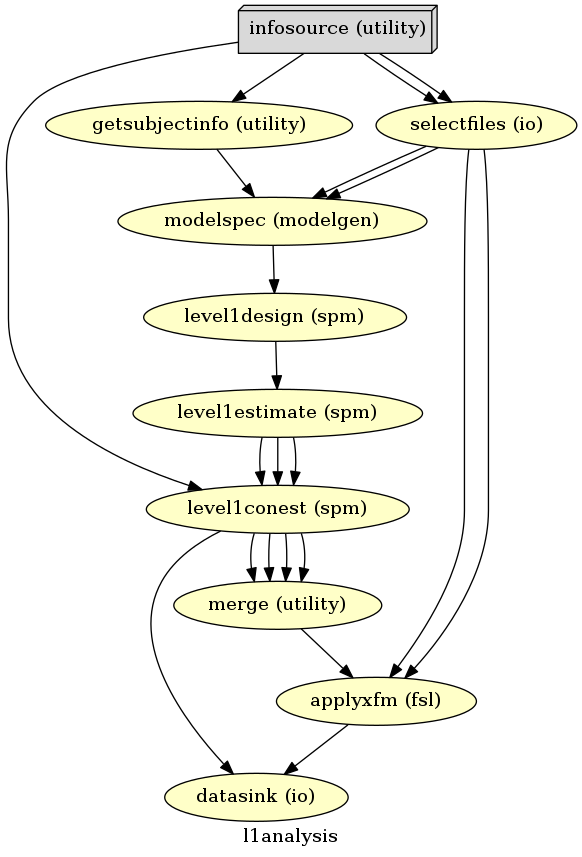

In [28]:
# Create 1st-level analysis output graph
l1analysis.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l1analysis.base_dir, 'l1analysis', 'graph.dot.png'))

#  Run the Workflow

Now that everything is ready, we can run the 1st-level analysis workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [29]:
l1analysis.run('MultiProc', plugin_args={'n_procs': 4})

170804-17:47:07,330 workflow INFO:
	 Workflow l1analysis settings: ['check', 'execution', 'logging']
170804-17:47:07,655 workflow INFO:
	 Running in parallel.
170804-17:47:07,664 workflow INFO:
	 Executing: getsubjectinfo.a19 ID: 0
170804-17:47:07,673 workflow INFO:
	 Executing node getsubjectinfo.a19 in dir: /output/workingdir/l1analysis/_fwhm_id_8_subject_id_sub-10/getsubjectinfo
170804-17:47:07,671 workflow INFO:
	 Executing: selectfiles.a19 ID: 1
170804-17:47:07,691 workflow INFO:
	 Executing: getsubjectinfo.a18 ID: 9
170804-17:47:07,704 workflow INFO:
	 Executing: selectfiles.a18 ID: 10
170804-17:47:07,706 workflow INFO:
	 Executing node getsubjectinfo.a18 in dir: /output/workingdir/l1analysis/_fwhm_id_4_subject_id_sub-10/getsubjectinfo170804-17:47:07,694 workflow INFO:
	 Executing node selectfiles.a19 in dir: /output/workingdir/l1analysis/_fwhm_id_8_subject_id_sub-10/selectfiles

170804-17:47:07,719 workflow INFO:
	 Executing node selectfiles.a18 in dir: /output/workingdir/l1anal

# Contrast 2, finger

In [31]:
from nilearn.plotting import plot_stat_map

### Lefthanded

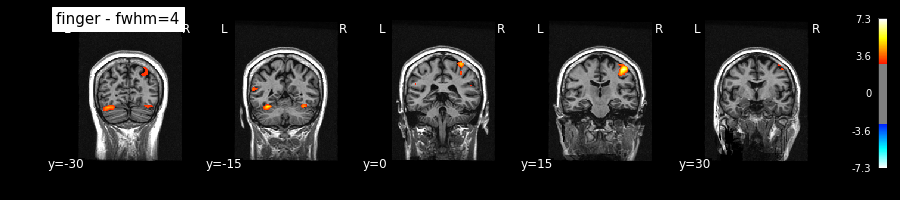

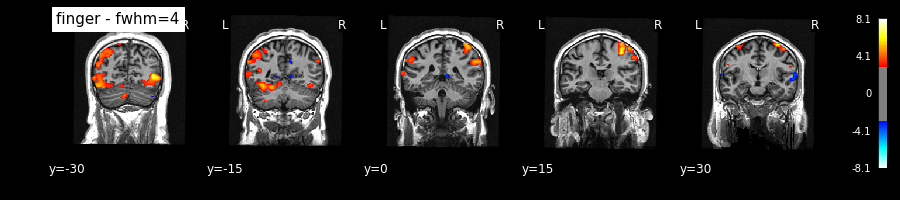

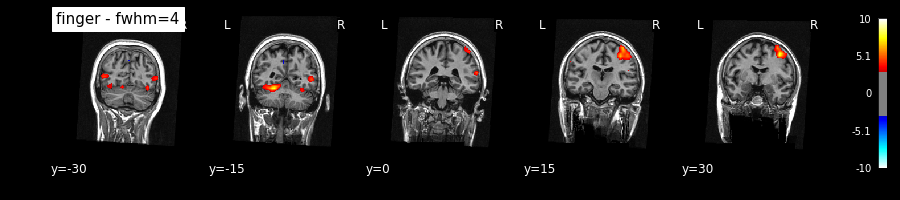

In [40]:
for ii in ["01", "06", "10"]:
    anatimg = '/data/ds000114/derivatives/fmriprep/sub-{0}/anat/sub-{0}_t1w_preproc.nii.gz'.format(ii)
    plot_stat_map(
        '/output/datasink/1stLevel/sub-{}/fwhm-4/spmT_0002.nii'.format(ii), title='finger - fwhm=4',
        bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-30, -15, 0, 15, 30), dim=-1)


### Righ

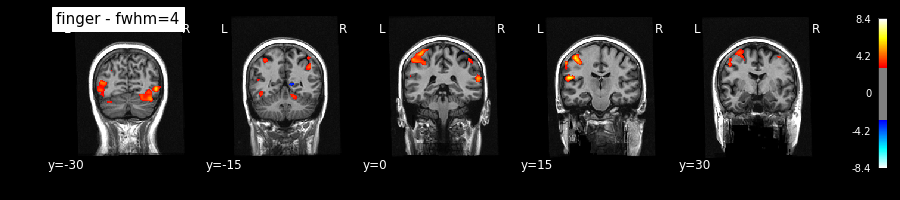

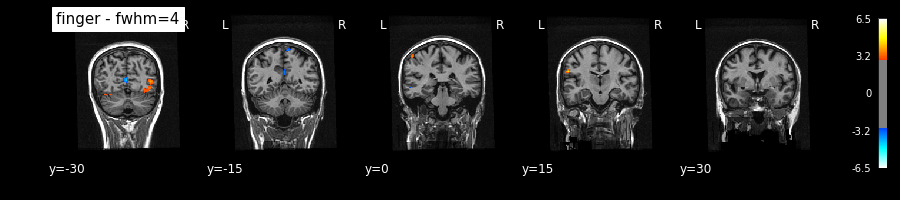

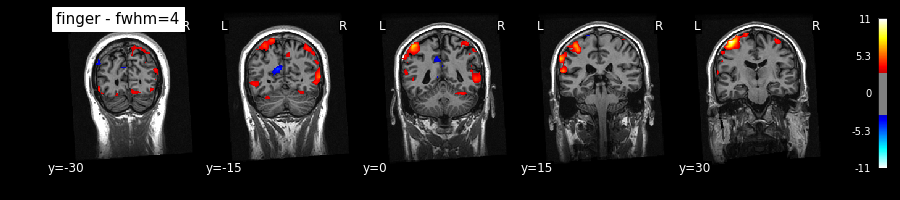

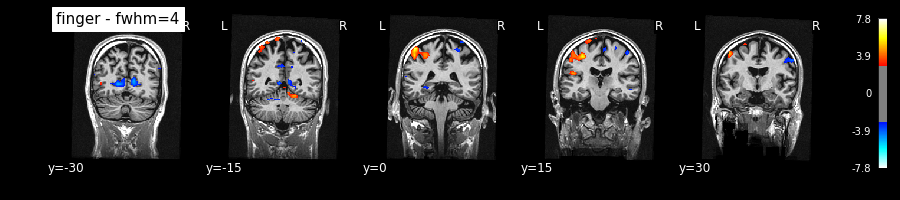

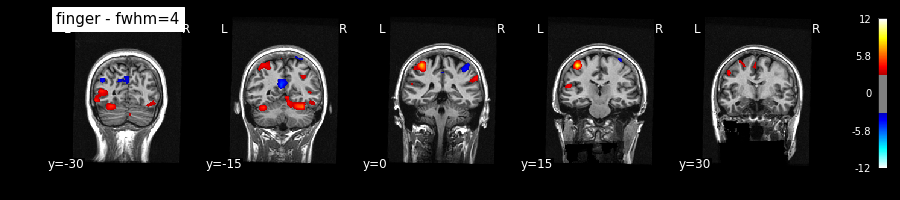

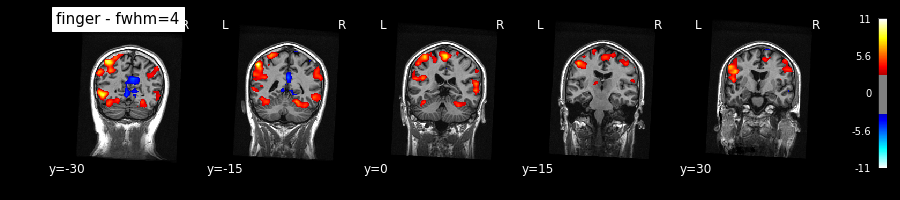

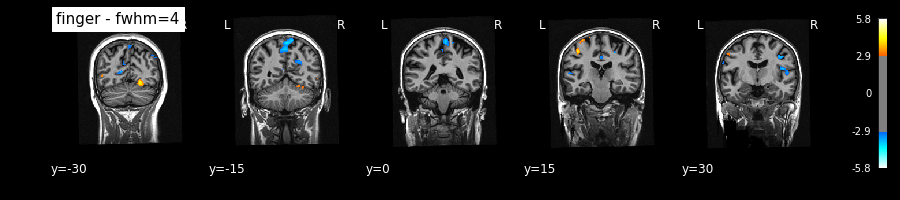

In [44]:
for ii in ["02", "03", "04", "05", "07", "08", "09"]:
    anatimg = '/data/ds000114/derivatives/fmriprep/sub-{0}/anat/sub-{0}_t1w_preproc.nii.gz'.format(ii)
    plot_stat_map(
        '/output/datasink/1stLevel/sub-{}/fwhm-4/spmT_0002.nii'.format(ii), title='finger - fwhm=4',
        bg_img=anatimg, threshold=3, display_mode='y', cut_coords=(-30, -15, 0, 15, 30), dim=-1)
